<a href="https://colab.research.google.com/github/davidho27941/2023_NDMC_medical_workshop/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using DCGAN to generate Chest X-Ray Image

為了您的使用體驗，建議使用Google Colab開啟此筆記本。


## Connect to colab notebook

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install Dependencies

In [67]:
!pip install -q pytorch-lightning rich

In [68]:
# @title 程式碼區塊 - 1 { display-mode: "form" }

# @markdown 程式碼編寫區塊，有興趣者請點擊"Show code"來瀏覽內容。

import psutil
import time
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

from glob import glob
from PIL import Image
from pathlib import Path
from functools import wraps
from datetime import datetime
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.utilities.types import STEP_OUTPUT

!rm -rf /content/lightning_logs

def timer(func):
    @wraps(func)
    def wrapper(*args, **kargs):
        prev_time = time.time()
        result = func(*args, **kargs)
        end_time = time.time()

        return result
    return wrapper

def img_loader(path, target_dim):
    _img = Image.open(path).convert("RGB")
    _img = _img.resize(target_dim, Image.ANTIALIAS)
    return np.asarray(_img)

def load_image(mode, targe_dim=(128, 128)):
    path_dict = get_data_path(mode)
    image_dict = {}
    for type, path in path_dict.items():
        img_list = [
            img_loader(_path, targe_dim)
            for _path in glob(f"{path}/*.jpeg")
        ]
        image_dict[type] = img_list

    return image_dict


def get_data_path(
    mode,
    ROOT_DIR=Path("/content/drive/MyDrive/chest_xray"),
):
    assert ROOT_DIR is not None, "請定義資料夾根目錄"

    if mode == 'train':
        TRAIN_DIR = ROOT_DIR / 'train'
        PNEUMONIA_DIR = TRAIN_DIR / 'PNEUMONIA'
        NORMAL_DIR = TRAIN_DIR / 'NORMAL'

    elif mode == 'test':
        TEST_DIR = ROOT_DIR / 'test'
        PNEUMONIA_DIR = TEST_DIR / 'PNEUMONIA'
        NORMAL_DIR = TEST_DIR / 'NORMAL'

    elif mode == 'val':
        VAL_DIR = ROOT_DIR / 'val'
        PNEUMONIA_DIR = VAL_DIR / 'PNEUMONIA'
        NORMAL_DIR = VAL_DIR / 'NORMAL'

    return {
        "PNEUMONIA": PNEUMONIA_DIR,
        "NORMAL": NORMAL_DIR,
    }

def get_num_files(dirList):
    for dir in dirList.values():
        num_files = len(glob(f"{dir}/*.jpeg"))
        print(f"目錄： {dir} 之中有 {num_files} 個檔案")

def img_loader(path, target_dim):
    _img = Image.open(path).convert("RGB")
    _img = _img.resize(target_dim, Image.LANCZOS)
    return np.asarray(_img)

class ChestXRay(Dataset):
    def __init__(
        self,
        mode: str,
        root_dir: str= Path('../chest_xray/'),
        image_dim =(128,128),
        if_mod_255=False,
    ) -> None:
        self.root_dir = root_dir
        self.mode = mode
        self.image_dim = image_dim
        self.data_list = self.get_data_list(self.mode)
        self.if_mod_255 = if_mod_255

    def get_data_list(self, mode):
        path_dict = get_data_path(mode, ROOT_DIR=self.root_dir)
        _file_list = []
        for type, path in path_dict.items():
            _tmp_list = glob(f"{path}/*.jpeg")
            for item in _tmp_list:
                _file_list.append(item)

        return _file_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        img = img_loader(self.data_list[index], self.image_dim)
        if self.if_mod_255:
            img = img/255.0
        img = torch.FloatTensor(img.copy())
        # label = torch.FloatTensor(self.labels[index])
        return img

def get_dataset(
    mode,
    root_dir=None,
    image_dim=(128, 128),
    if_mod_255=False,
):
    dataset = ChestXRay(
        mode,
        root_dir = root_dir,
        image_dim=image_dim,
        if_mod_255=if_mod_255,
    )
    return dataset

def get_dataloader(
    mode,
    batch_size,
    shuffle=False,
    root_dir=None,
    image_dim=(128, 128),
    if_mod_255=False,
):
    dataset = get_dataset(
        mode,
        root_dir=root_dir,
        image_dim=image_dim,
        if_mod_255=if_mod_255
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=True,
        num_workers=4,
    )
    return dataloader

def preflight_check(ROOT_DIR):
    assert os.path.exists(ROOT_DIR), (
        "經查，您所輸入的資料夾位置不存在，請確認是否有掛載雲端硬碟，或是輸入錯誤。"
    )
    TRAIN_DIRS = get_data_path('train', ROOT_DIR=ROOT_DIR)
    TEST_DIRS = get_data_path('test', ROOT_DIR=ROOT_DIR)
    VAL_DIRS = get_data_path('val', ROOT_DIR=ROOT_DIR)
    DIRS_TOTAL = {
        **TRAIN_DIRS,
        **TEST_DIRS,
        **VAL_DIRS,
    }

    for _dir in DIRS_TOTAL.values():
        assert os.path.exists(_dir), (
            f"子資料夾 {_dir} 不存在, 請確認檔案正確性"
        )


class DiscriminatorUtils:
    @staticmethod
    def define_first_layer(n_channels: int):
        layer_1 = nn.Conv2d(
            in_channels=3,
            kernel_size=(5,5),
            out_channels=NUM_CHANNELS,
            padding='same'
        )
        layer_2 = nn.LeakyReLU(0.2)
        return [layer_1, layer_2]

    @staticmethod
    def define_downsampling_layers(
        NUM_DOWN_SAMPLING_LAYER: int,
        NUM_CHANNELS: int,
    ):
        _conv_layer = nn.Conv2d(
            in_channels=NUM_CHANNELS,
            kernel_size=(2,2),
            stride=(2,2),
            out_channels=NUM_CHANNELS
        )
        _layer_norm = nn.LeakyReLU(0.2)

        layers = []
        for _ in range(NUM_DOWN_SAMPLING_LAYER):
            layers.append(_conv_layer)
            layers.append(_layer_norm)
        return layers

    @staticmethod
    def define_dropout(dropout_rate: float):
        return nn.Dropout(dropout_rate)

    @staticmethod
    def define_flatten():
        return nn.Flatten()

    @staticmethod
    def define_final_layers(
        NUM_CHANNELS: int,
        final_size: int,
        activation='sigmoid',
    ):

        layer_1 = nn.Linear(
            in_features=NUM_CHANNELS*final_size*final_size,
            out_features=1
        )
        layer_2 = (
            nn.Sigmoid()
            if activation == 'sigmoid' else nn.Softmax()
        )
        return [layer_1, layer_2]

def build_discriminator(
    ORIGINAL_IMAGE_SIZE: int,
    NUM_DOWN_SAMPLING_LAYER: int,
    NUM_CHANNELS: int,
    final_size: int,
    dropout_rate: float,
    activation_fn: str,
):

    first_layer = DiscriminatorUtils.define_first_layer(NUM_CHANNELS)
    downsampling_layers = DiscriminatorUtils.define_downsampling_layers(
        NUM_DOWN_SAMPLING_LAYER,
        NUM_CHANNELS,
    )
    flatten_layer = DiscriminatorUtils.define_flatten()
    dropout_layer = DiscriminatorUtils.define_dropout(dropout_rate)
    final_layers = DiscriminatorUtils.define_final_layers(
        NUM_CHANNELS,
        final_size,
        activation=activation_fn,
    )

    all_layers = [
        *first_layer,
        *downsampling_layers,
        flatten_layer,
        dropout_layer,
        *final_layers,
    ]

    d_model = nn.Sequential(*all_layers)
    return d_model

class GeneratorUtils:
    @staticmethod
    def define_first_layer(
        NOISE_SERIES_LENGTH: int,
        NOISE_IMAGE_SIZE: int,
        NUM_CHANNELS: int,
    ):
        layer_1 = nn.Linear(
            in_features=NOISE_SERIES_LENGTH,
            out_features=NUM_CHANNELS*NOISE_IMAGE_SIZE*NOISE_IMAGE_SIZE
        )

        layer_2 = nn.LeakyReLU(0.2)

        layer_3 = nn.Unflatten(
            1,
            (NUM_CHANNELS, NOISE_IMAGE_SIZE, NOISE_IMAGE_SIZE),
        )

        return [layer_1, layer_2, layer_3]

    @staticmethod
    def define_upsampling_layers(
        NUM_CHANNELS: int,
        NUM_UP_SAMPLING_LAYER: int,
    ):

        _upsampling_layer = nn.ConvTranspose2d(
            in_channels=NUM_CHANNELS,
            kernel_size=(4,4),
            stride=(2,2),
            padding=(1,1),
            out_channels=NUM_CHANNELS,
        )

        _layer_norm = nn.LeakyReLU(0.2)

        layers = []
        for _ in range(NUM_UP_SAMPLING_LAYER):
            layers.append(_upsampling_layer)
            layers.append(_layer_norm)

        return layers

    @staticmethod
    def define_final_layers(
        NUM_CHANNELS: int,
    ):
        layer_1 = nn.Conv2d(
            in_channels=NUM_CHANNELS,
            kernel_size=(4,4),
            padding='same',
            out_channels=3
        )
        layer_2 = nn.Tanh()
        return [layer_1, layer_2]

def build_generator(
    NOISE_SERIES_LENGTH: int,
    NOISE_IMAGE_SIZE: int,
    NUM_CHANNELS: int,
    NUM_UP_SAMPLING_LAYER: int,
):
    first_layer = GeneratorUtils.define_first_layer(
        NOISE_SERIES_LENGTH,
        NOISE_IMAGE_SIZE,
        NUM_CHANNELS,
    )
    upsampling_layers = GeneratorUtils.define_upsampling_layers(
        NUM_CHANNELS,
        NUM_UP_SAMPLING_LAYER,
    )
    final_layers = GeneratorUtils.define_final_layers(
        NUM_CHANNELS,
    )

    all_layers = [
        *first_layer,
        *upsampling_layers,
        *final_layers,
    ]
    g_model = nn.Sequential(*all_layers)
    return g_model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = build_generator()

    def forward(self, x):
        # print(x.size())
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(
        self,
        input_shape=(128,128),
    ):
        super(Discriminator, self).__init__()
        self.model = build_discriminator()

    def forward(self, x):
        return self.model(x)

    def show_image(self, x):
        out = self.model(x)
        out = out.permute(0, 2, 3, 1)
        return out

In [ ]:
# @title 程式碼區塊 - 2 { display-mode: "form" }

# @markdown 程式碼編寫區塊，有興趣者請點擊"Show code"來瀏覽內容。
class DCGAN(pl.LightningModule):
    def __init__(
        self,
        generator,
        discriminator,
        lr=2e-4,
        b1: float = 0.5,
        b2: float = 0.999,
        img_size=(128, 128),
        latent_dim=128,
        loss='binary_cross_entropy'
    ):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.loss = loss

        self.save_hyperparameters(ignore=['generator', 'discriminator'])
        self.automatic_optimization = False

        self.configure_loss()

    def configure_loss(self):
        self.loss_fn = (
            F.binary_cross_entropy
            if self.loss == 'binary_cross_entropy'
            else F.mse_loss
        )

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(
            self.generator.parameters(),
            lr=lr,
            betas=(b1, b2)
        )
        opt_d = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=lr,
            betas=(b1, b2)
        )
        return [opt_g, opt_d], []

    def generate_noise(self, img):
        z = torch.randn(img.shape[0], self.hparams.latent_dim)
        z = z.type_as(img)
        return z

    def adversarial_loss(self, y_hat, y):
        return self.loss_fn(y_hat, y)

    def training_step(self, batch):
        img = batch

        optimizer_g, optimizer_d = self.optimizers()
        z = self.generate_noise(img)

        self.toggle_optimizer(optimizer_g)

        noise = self.generate_noise(img)
        fake_image = self.generator(noise)

        sample_imgs = fake_image[:6]
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image(
            f"generated_images-{datetime.now():%Y-%m-%d %H:%M:%S}",
            grid,
            0
        )

        truth = torch.ones(img.size(0), 1)
        truth = truth.type_as(img)

        g_loss = self.adversarial_loss(
            self.discriminator(fake_image),
            truth
        )

        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()

        self.untoggle_optimizer(optimizer_g)

        self.toggle_optimizer(optimizer_d)

        # how well can it label as real?
        truth = torch.ones(img.size(0), 1)
        truth = truth.type_as(img)

        real_loss = self.adversarial_loss(
            self.discriminator(img.permute(0, 3, 1, 2)),
            truth
        )

        # how well can it label as fake?
        fake = torch.zeros(img.size(0), 1)
        fake = fake.type_as(img)

        fake_loss = self.adversarial_loss(
            self.discriminator(self.generator(noise).detach()),
            fake
        )

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)


In [69]:
# @title 基本定義

# @markdown 定義圖片根目錄位置

ROOT_DIR = "/content/drive/MyDrive/chest_xray" #@param {type:"string"}
ROOT_DIR = Path(ROOT_DIR)

# @markdown 定義要輸入到模型的相片大小（長寬相等）

IMAGE_SIZE = "128" #@param [64, 128, 256]
IMAGE_SIZE = int(IMAGE_SIZE)

# @markdown 定義是否執行資料夾檢測

IF_CHECK_FOLDER = True # @param [True, False] {type:"boolean"}

print(
f"""
您所定義的參數如下：

影像尺寸：
    長： {IMAGE_SIZE}
    寬： {IMAGE_SIZE}

資料根目錄位置：
    {ROOT_DIR}
"""
)

if IF_CHECK_FOLDER:
    preflight_check(ROOT_DIR)
else:
    print("資料夾結構驗證已停用，請確保您使用的資料均已正確上傳！")

TRAIN_DIRS = get_data_path('train', ROOT_DIR=ROOT_DIR)
TEST_DIRS = get_data_path('test', ROOT_DIR=ROOT_DIR)
VAL_DIRS = get_data_path('val', ROOT_DIR=ROOT_DIR)

get_num_files(TRAIN_DIRS)
get_num_files(TEST_DIRS)
get_num_files(VAL_DIRS)



您所定義的參數如下：

影像尺寸：
    長： 128
    寬： 128

資料根目錄位置：
    /content/drive/MyDrive/chest_xray

目錄： /content/drive/MyDrive/chest_xray/train/PNEUMONIA 之中有 3911 個檔案
目錄： /content/drive/MyDrive/chest_xray/train/NORMAL 之中有 1341 個檔案
目錄： /content/drive/MyDrive/chest_xray/test/PNEUMONIA 之中有 390 個檔案
目錄： /content/drive/MyDrive/chest_xray/test/NORMAL 之中有 234 個檔案
目錄： /content/drive/MyDrive/chest_xray/val/PNEUMONIA 之中有 8 個檔案
目錄： /content/drive/MyDrive/chest_xray/val/NORMAL 之中有 8 個檔案


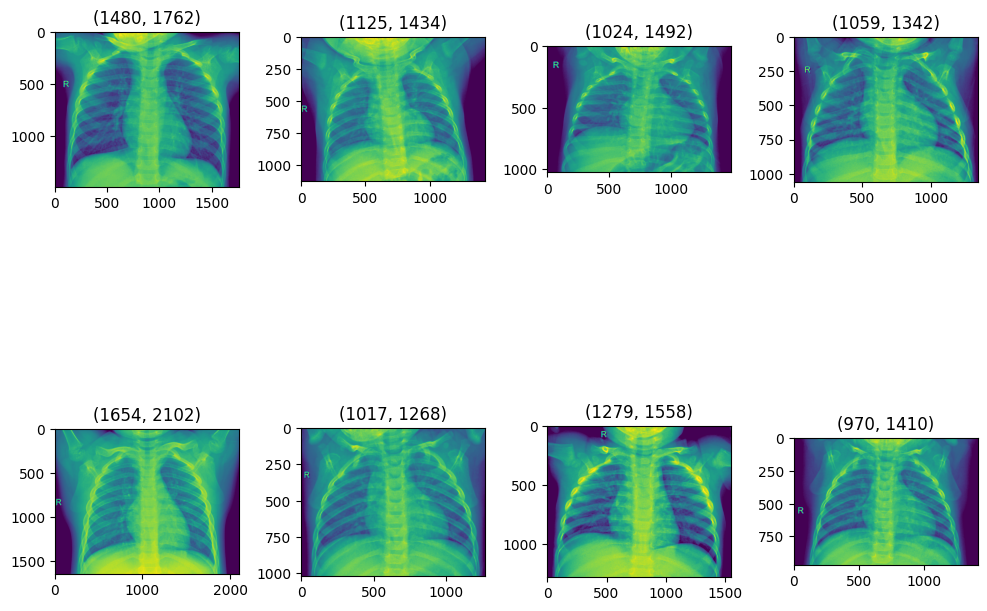

In [70]:
# @title 資料視覺化

# @markdown 我們可以嘗試讀取八張訓練照片來觀察原始資料的樣態。

train_normal_images = [
    plt.imread(dir)
    for dir in list(TRAIN_DIRS['NORMAL'].iterdir())[:8]
]

n_row, n_col = 2, 4
fig, ax = plt.subplots(n_row, n_col, figsize=(10, 8))
fig.tight_layout()

for idx, img in enumerate(train_normal_images):
    row = idx // 4
    col = idx % 4
    _ax = ax[row][col]
    _ax.imshow(img)
    _ax.set_title(img.shape)

In [71]:
# @title 為訓練資料建立資料管線

# @markdown 定義單一批次所訓練的影像數量

BATCH_SIZE = 32 #@param [16, 32, 64, 128]

# @markdown 定義要輸入到模型的相片大小（長寬相等）

IMAGE_SIZE = "128" #@param [64, 128, 256]
IMAGE_SIZE = int(IMAGE_SIZE)

# @markdown 定義是否進行資料正規化（除以255）

IF_MODE_255 = True # @param [True, False] {type:"boolean"}

# @markdown 定義是否進行資料隨機排序

IF_SHUFFLE =  True # @param [True, False] {type:"boolean"}

mode = 'train'

train_dataloader = get_dataloader(
    mode,
    BATCH_SIZE,
    shuffle=IF_SHUFFLE,
    root_dir=ROOT_DIR,
    image_dim=(IMAGE_SIZE, IMAGE_SIZE),
    if_mod_255=IF_MODE_255,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [72]:
# @title ## 建立判別器


#@markdown 定義降採樣層數量

NUM_DOWN_SAMPLING_LAYER = 4 #@param {type:"slider", min:2, max:5, step:1}

#@markdown 定義通道數量

NUM_CHANNELS = 128 #@param {type:"slider", min:100, max:200, step:1}

#@markdown 定義激勵函數

activation_fn = "sigmoid" #@param ["sigmoid", "softmax"]

#@markdown 定義Dropout機率
dropout_rate = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}

ORIGINAL_IMAGE_SIZE = IMAGE_SIZE

final_size = int(ORIGINAL_IMAGE_SIZE / (2**(NUM_DOWN_SAMPLING_LAYER)) )

assert final_size > 7, f"當最終產出尺寸太小時，將導致學習難度上升！（目前最終尺寸： {final_size}*{final_size}）"

discriminator = build_discriminator(
    ORIGINAL_IMAGE_SIZE,
    NUM_DOWN_SAMPLING_LAYER,
    NUM_CHANNELS,
    final_size,
    dropout_rate,
    activation_fn,
)
print(f"你建立的判別器模型如下：\n{discriminator}")

你建立的判別器模型如下：
Sequential(
  (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (3): LeakyReLU(negative_slope=0.2)
  (4): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (5): LeakyReLU(negative_slope=0.2)
  (6): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (9): LeakyReLU(negative_slope=0.2)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=8192, out_features=1, bias=True)
  (13): Sigmoid()
)


In [73]:
# @title ## 建立生成器

# @markdown 定義生成雜訊的長度

NOISE_SERIES_LENGTH = 128 #@param {type:"slider", min:32, max:256, step:2}

NOISE_IMAGE_SIZE = 8

NUM_UP_SAMPLING_LAYER = int(np.log2(IMAGE_SIZE) - 3)

generator = build_generator(
    NOISE_SERIES_LENGTH,
    NOISE_IMAGE_SIZE,
    NUM_CHANNELS,
    NUM_UP_SAMPLING_LAYER,
)
print(f"你建立的生成器模型如下：\n{generator}")


你建立的生成器模型如下：
Sequential(
  (0): Linear(in_features=128, out_features=8192, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Unflatten(dim=1, unflattened_size=(128, 8, 8))
  (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2)
  (5): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): LeakyReLU(negative_slope=0.2)
  (7): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (10): LeakyReLU(negative_slope=0.2)
  (11): Conv2d(128, 3, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (12): Tanh()
)


In [75]:
# @title 建立模型

# @markdown 請選擇損失函數

loss = 'mean_square_error' # @param ["binary_cross_entropy", "mean_square_error"]

# @markdown 請選擇學習率

lr = 0.0002 # @param {type:"slider", min:0.0002, max:0.002, step:0.0001}

LitModule = DCGAN(
    generator,
    discriminator,
    img_size=(IMAGE_SIZE, IMAGE_SIZE),
    latent_dim=NOISE_SERIES_LENGTH,
    loss=loss,
    lr=lr,
)

In [76]:
# @title 建立訓練函數

# @markdown 請選擇要訓練的週期數量

EPOCHS = 20 #@param {type:"slider", min:10, max:100, step:10}

accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    devices=1,
    accelerator=accelerator,
    callbacks=[
        pl.callbacks.RichProgressBar(),
        pl.callbacks.EarlyStopping(
            'd_loss',
            patience=7,
            mode='min',
            divergence_threshold=1.0,
            verbose=1,
        ),
        pl.callbacks.RichModelSummary(
            max_depth=4,
        ),
    ],
)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# @title 開始訓練

# @markdown 執行此區塊以開始訓練。

trainer.fit(
    LitModule,
    train_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name             ┃ Type            ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ generator        │ Sequential      │  1.3 M │
│ 1  │ generator.0      │ Linear          │  1.1 M │
│ 2  │ generator.1      │ LeakyReLU       │      0 │
│ 3  │ generator.2      │ Unflatten       │      0 │
│ 4  │ generator.3      │ ConvTranspose2d │  262 K │
│ 5  │ generator.4      │ LeakyReLU       │      0 │
│ 6  │ generator.11     │ Conv2d          │  6.1 K │
│ 7  │ generator.12     │ Tanh            │      0 │
│ 8  │ discriminator    │ Sequential      │ 83.6 K │
│ 9  │ discriminator.0  │ Conv2d          │  9.7 K │
│ 10 │ discriminator.1  │ LeakyReLU       │      0 │
│ 11 │ discriminator.2  │ Conv2d          │ 65.7 K │
│ 12 │ discriminator.3  │ LeakyReLU       │      0 │
│ 13 │ discriminator.10 │ Flatten         │      0 │
│ 14 │ discriminator.11 │ Dropout         │      0 │
│ 15 │ discriminator.12 │ Linear          │  8.2 K │
│ 16 │ discriminator.13 │ Sigmoid         │      0 │
└────┴──────────────────┴─────────────────┴────────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric d_loss improved. New best score: 0.221


In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
# !cp -r lightning_logs /content/drive/MyDrive/chest_xray/record_20230729_2200